In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths,\
confusion_matrix



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [7]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [8]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [9]:
%%time
path_figs = './figs/20kX/'
save = True
Path(path_figs).mkdir(exist_ok = True, parents = True)


CPU times: user 129 µs, sys: 77 µs, total: 206 µs
Wall time: 373 µs


In [10]:
%%time

N,D = 2*10**4, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.25,0.25],[0.5,0.5],[0.75,0.75],[0.75,0.25], [0.25,0.75]]
r_small = [0.122]*5
r_big = [0.2,0.2,0.2, 0.2,0.2]
kw_cluster =  {'f_class_name':'circle_class3', 'centers': centers, 'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 5
stats = np.array([[1, std], [0, std], [0, std], [0, std],[0, std],
                  [0, std],[1, std],[1, std],[2, std],[3, std],[4, std],[5, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:121, Number of Points:20000
CPU times: user 89.4 ms, sys: 16.9 ms, total: 106 ms
Wall time: 164 ms


In [11]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,0,0,3.046737,-0.670012,-3.716749
1,0.602763,0.544883,0,0,-12.710297,8.679807,21.390104
2,0.423655,0.645894,2,0,5.168985,-11.989884,-17.158869
3,0.437587,0.891773,0,0,3.842964,1.617715,-2.225249
4,0.963663,0.383442,0,0,1.522925,15.902760,14.379835


In [12]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.495176,0.500139,1.130250,0.502900,1.177638,1.221437,1.102429
std,0.289365,0.289445,1.721346,0.500004,5.101396,5.149392,7.263410
min,0.000072,0.000074,0.000000,0.000000,-19.500127,-23.260588,-28.349920
25%,0.243445,0.248979,0.000000,0.000000,-2.284797,-2.274898,-3.771657
50%,0.495403,0.499194,0.000000,1.000000,1.164745,1.197306,1.092328
75%,0.743434,0.754316,2.000000,1.000000,4.597291,4.645637,5.953737
max,0.999962,0.999978,5.000000,1.000000,23.834711,21.010989,30.715434


In [13]:
#mpl.style.use(['seaborn-paper'])
#mpl.rcParams.update(mpl.rcParamsDefault)


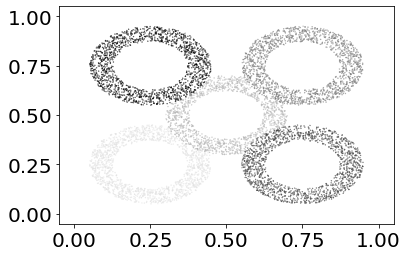

In [14]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

if save:
    fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [15]:
from econml.metalearners import XLearner as XL
from sklearn.ensemble import RandomForestClassifier as RF

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### Train X learner to directly calculate effect
#### Use gradient boosting trees for estimation models and  loistic Regression for Rest

In [16]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

m0 = GDBR(**f1_kwargs)
m1 = GDBR(**f1_kwargs)
t0 = GDBR(**f1_kwargs)
t1 = GDBR(**f1_kwargs)

model = XL((m0,m1), (t0,t1), categories=[0,1])
xml = model.fit(data.Y, data.Treatment, X = data[['x0','x1']])

CPU times: user 1min 22s, sys: 94.2 ms, total: 1min 23s
Wall time: 1min 22s


### Get Xlearner Effects and add it as a column to the data

In [17]:
data['ITE-XML'] = xml.effect(data[['x0','x1']])
print(data['ITE-XML'].min(), data['ITE-XML'].max())

-18.20106539721533 19.256012362884434


### Xlearner Effect histogram 

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


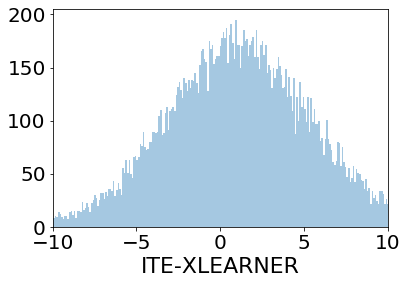

In [18]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)


fig, ax = plt.subplots()

bins = 400
ax = sns.distplot(data['ITE-XML'],  bins=bins, kde = False,ax = ax)
ax.set_xlabel('ITE-XLEARNER')

ax.set_xlim(-10,10)
if save:
    fig.savefig(path2+'xlearnhist.pdf', bbox_inches='tight',pad_inches = 0)

### 3Clustering of Xlearner effects

In [19]:
cluster_name = 'ITE-XML-3Clust'
col = 'ITE-XML'
filt11 = data[col] <= 0.5
filt21 = data[col] >= 0.5
filt31 = data[col] >= 1.5
filt41 = data[col] >= 2.5
filt51 = data[col] >= 3.5
filt61 = data[col] >= 4.5

data[cluster_name] = 0
data.loc[filt11,cluster_name] = 0
data.loc[filt21, cluster_name] = 1
data.loc[filt31, cluster_name] = 2
data.loc[filt41,cluster_name] = 3
data.loc[filt51, cluster_name] = 4
data.loc[filt61, cluster_name] = 5

#data,_ = kmeans_clustering(data, clusters = 3, cluster_name = 'ITE-XML-3Clust',col_select = ['ITE-XML'] )

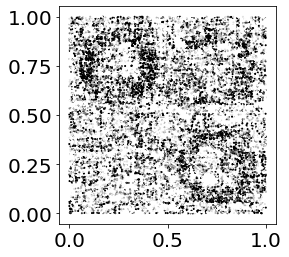

In [20]:
path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)

fig, ax = plt.subplots()

sc = ax.scatter(data['x0'].values, data['x1'].values, c=data['ITE-XML-3Clust'], cmap = 'Greys', s = 1)
if save:
        ax.set_aspect('equal', adjustable='box')
        fig.savefig(path3+'{}.jpeg'.format('ITE-XML-3Clust'), bbox_inches='tight',pad_inches = 0)

### Xlearner 6Clustering mean absolute error versu eligibility

In [21]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group

In [22]:
ite_column = 'ITE-XML'
clust2 = 'ITE-XML-3Clust'
data = data.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

In [23]:
errors = data.describe().loc[['mean', 'std'], [col for col in data.columns if 'err' in col]].T

In [24]:
errors

,mean,std
ITE-XML-3Clust-err-GDBR,3.246373,1.836821


In [25]:
from IPython.display import display

path4 = path_figs+'matrices/'
Path(path4).mkdir(exist_ok = True)

mat = confusion_matrix(data, 'C', 'ITE-XML-3Clust', 6, save = save, save_dir = path4)
display(mat)

,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.531181,0.095748,0.088189,0.076850,0.060315,0.147717
C1 True,0.497574,0.104643,0.106722,0.083853,0.063756,0.143451
C2 True,0.373057,0.100173,0.101036,0.080311,0.090674,0.254750
C3 True,0.265978,0.090381,0.105229,0.101356,0.104584,0.332473
C4 True,0.205029,0.081883,0.094133,0.098646,0.099936,0.420374
C5 True,0.153221,0.065041,0.075047,0.080675,0.093809,0.532208


In [26]:
data.groupby('ITE-XML-3Clust').mean()

,x0,x1,C,Treatment,Y,Ycf,ITE,ITE-XML,ITE-XML-3Clust-err-GDBR
ITE-XML-3Clust,,,,,,,,,
0,0.487118,0.482985,0.599143,0.504678,1.000984,1.065775,-2.280309,-2.742277,3.341421
1,0.495910,0.492409,0.987594,0.492988,1.147821,1.304163,1.003560,0.990156,1.296284
2,0.495801,0.501474,1.132418,0.519780,1.171719,1.195413,1.624086,1.991191,1.759663
3,0.497606,0.502303,1.249233,0.488643,1.225311,1.209909,2.826428,2.986210,2.249014
4,0.510055,0.504154,1.509091,0.508392,1.210266,1.278048,3.715079,3.980426,2.689475
5,0.505127,0.535354,2.093949,0.500000,1.520869,1.497300,6.265684,7.137224,5.043275


In [27]:
np.mean(np.abs(data['C'] - data['ITE-XML'])), np.std(np.abs(data['C'] - data['ITE-XML']))

(3.2694448880456966, 2.5362092114200316)